<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
#Importing Dependencies
import requests
import bs4
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import csv

#Importing Sci-kit + Stats Models Dependencies
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

#Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

#GridSearch
from sklearn.model_selection import GridSearchCV

#Pre-processing
from sklearn.preprocessing import StandardScaler

#Scipy Integration for Sparse Matrixes
from scipy import sparse

#Plotting & Visualisation Metrics
from matplotlib import pyplot as plt
import seaborn as sns

#Scoring & Evaluation Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [ ]:
# How to operate a HTTP requests object.

base_url = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

req = requests.get(base_url)
soup = BeautifulSoup(req.text, 'html.parser')
results = []

for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
    results.append(item)

In [ ]:
# How to operate a HTTP requests object.
req = requests.get('https://www.indeed.co.uk/jobs?q=data+science+£40,000&l=London')
soup = BeautifulSoup(req.text, 'html.parser')
results = []

for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
    if item.find('span', class_='salary') is not None:
        print('test')
    else:
        print('no salary')
#     results.append(item)


Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

-----------------------------------------------------------------------------------------------------------------------------

In [ ]:
def extract_salaries(soup, np=np):
    salaries = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                salaries.append(item.find('span', class_='salary').getText().strip().replace('\n', ''))
            except:
                salaries.append(np.nan)
        else:
            pass
    return salaries

In [ ]:
def extract_titles(soup, np=np):
    titles = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                titles.append(item.find('div', class_='title').getText().strip())
            except:
                titles.append(np.nan)
        else:
            pass
    return titles

In [ ]:
def extract_locations(soup, np=np):
    locations = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                locations.append(item.find('span', class_='location').getText().replace('\n','').strip())
            except:
                locations.append(np.nan)
        else:
            pass
    return locations

In [ ]:
def extract_companies(soup, np=np):
    companies = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                companies.append(item.find('span', class_='company').getText().replace('\n','').strip())
            except:
                companies.append(np.nan)
        else:
            pass
    return companies

In [ ]:
## 🔥🚀 #Let's scrape the companies ratings (the maximum width is 60px so we can use this as 100%) 🔥🚀

def extract_ratings(soup, np=np):
    import re
    ratings = []
    for item in soup.find_all('div', class_='jobsearch-SerpJobCard'):
        if item.find('span', class_='salary') is not None:
            try:
                width = item.find('span',class_='rating').attrs['style']
                rating = float(findall(':([^p]+)', width)[0])
                ratings.append((round(((rating / 60) * 100))))
            except:
                ratings.append(np.nan)
        else:
            pass
    return ratings    

In [ ]:
# Let's extract all of the delightful ahref <a> links for the individual job listings.

def extract_links(soup, np=np):
    urls = []
    for item in soup.find_all('div', class_='result'):
        if item.find('span', class_='salary') is not None:
            try:
                urls.append('https://www.indeed.com' + item.find('a').attrs['href'])
            except:
                urls.append(np.nan)
        else:
            pass
    return urls

-----------------------------------------------------------------------------------------------------------------------------

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [ ]:
from IPython.display import clear_output

In [ ]:
YOUR_CITY = 'London'

In [ ]:
city_list = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]

In [ ]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 150 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

# results = {
#     'Salaries($)': [],
#     'Titles': [],
#     'Locations': [],
#     'Companies': [],
#     'Ratings': [],
#     'URL_Listings': []
# }


with open('test.csv', 'a') as f:
    w = csv.writer(f)
    for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
        'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
        'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):

        page_index = 0

        for start in range(0, max_results_per_city):
            
            clear_output(wait=True)
            #Let's Create An Index For The URL's.
            page_index += 10

            #Let's Make The URL Dynamnic Via Formatting.
            user_agent = {'User-agent': 'Mozilla/5.0'}
            dynamic_url = url_template.format(city, page_index)
            req = requests.get(dynamic_url)
            soup = BeautifulSoup(req.text, 'html.parser')

#             Appending The Results To A Dictionary!
#             results['Salaries($)'].extend(extract_salaries(soup))
#             results['Titles'].extend(extract_titles(soup))
#             results['Locations'].extend(extract_locations(soup))
#             results['Companies'].extend(extract_companies(soup))
#             results['Ratings'].extend(extract_ratings(soup))
#             results['URL_Listings'].extend(extract_links(soup))
            
            
            #This method allows us to save intermediate results for web scraping via a CSVwriterows Append.
            data = [list(item) for item in list(zip(extract_salaries(soup),extract_titles(soup)
                                                    ,extract_locations(soup), extract_companies(soup),
                                                    extract_companies(soup), extract_ratings(soup), 
                                                    extract_links(soup)))]
            w.writerows(data)
            print(city, page_index)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [ ]:
#To avoid Pandas truncating our Listing_URL columns, let's increase the max_colwidth.

pd.set_option("display.max_colwidth", 10000)
df = pd.DataFrame(results, columns = list(results.keys()))

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [ ]:
#Let's filter out of all of the null salary entries and any entries that contain hour.

df = df[(df['Salaries($)'].notnull()) & (df['Salaries($)'].str.contains('hour') == False)]

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [ ]:
#Solving the string manipulation problem with Regex and an IF statement for months vs years.

def convert_digits(a):
    import re

    #If there is a month in the string.
    digits = []
    if 'month' in a:
        for x in a.split():
                x_ = x.replace(',','')
                x_ = re.sub('[$,£]', '', x_)
                if x_.isdigit():
                    year_figure = (int(x_) * 12)
                    digits.append(year_figure)

        if len(digits) == 1:
            return digits[0]

        else:
            return sum(digits) / len(digits)

    #If there is no month in the string.

    else:
        for x in a.split():
            x_ = x.replace(',','')
            x_ = re.sub('[$,£]', '', x_)
            if x_.isdigit():
                digits.append(int(x_))

        if len(digits) == 1:
            return digits[0]

        else:
            return sum(digits) / len(digits)

In [ ]:
#Let's apply our formula to extract all of the rows.

df['Salaries($)'] = df['Salaries($)'].apply(convert_digits)

In [ ]:
### Data Cleaning ### - After scraping data for several days, now we can remove any of the duplicates.

df = pd.DataFrame.drop_duplicates(df)

In [ ]:
# Let's clean up the locations column.

def locations(a):
    import re
    result = re.sub(r"[0-9]", "", str(a))
    return re.sub(r'\([^)]*\)', '', result)

df['Locations'] = df['Locations'].apply(locations)

### Save your results as a CSV

In [ ]:
# # Let's export the dataframe into a CSV format.
# export_csv = cleaned_df.to_csv('exported_dataframe.csv', index= None, header=True)

### The Code Below Allows Us To Append To Our Existing CSV Data From Multiple Scrapes

In [ ]:
df.to_csv('exported_dataframe.csv', mode='a', header=False, index=False)

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

#### Load in the the data of scraped salaries

In [196]:
cleaned_df = pd.read_csv("exported_dataframe.csv")

In [178]:
cleaned_df[cleaned_df['Salaries($)'] < 10000].

,Salaries($),Titles,Locations,Companies,Ratings
6,5000.0,Lead Data Scientist – Digital Engagement,"Denver, CO",AETNA,NaN
8,5000.0,UX Copywriter / Content Strategist,"Denver, CO",AETNA,NaN
21,838.0,Technician B - Preventive Medicine,"New York, NY",Columbia University,NaN
89,1200.0,Field Application Scientist / Sr. Field Applic...,"San Francisco, CA",Benchling,NaN
96,1800.0,Software Engineer - Data Team,"Austin, TX",The Zebra,NaN
162,5000.0,UX Copywriter / Content Strategist,"Denver, CO",AETNA,72.0
221,1800.0,Software Engineer - Data Team,"Austin, TX",The Zebra,85.0
233,1579.0,CPA - Tax Research Analyst - Austin (Part-Time...,"Austin, TX",COMPTROLLER OF PUBLIC ACCOUNTS,52.0
279,5000.0,Lead Data Scientist – Digital Engagement,"Denver, CO",AETNA,72.0
299,838.0,Technician B - Preventive Medicine,"New York, NY",Columbia University,86.0


In [172]:
cleaned_df.describe()

,Salaries($),Ratings
count,544.000000,288.000000
mean,97740.238051,80.010417
std,41983.902457,11.395483
min,838.000000,32.000000
25%,66525.000000,72.000000
50%,100000.000000,85.000000
75%,125000.000000,88.000000
max,500000.000000,100.000000


In [74]:
# cleaned_df = cleaned_df.drop_duplicates()

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [75]:
# Calculating The Median.

median = cleaned_df['Salaries($)'].median()
print(median)

100000.0


In [76]:
def salary_class (x, median=median):
    if x > median:
        return 'HIGH SALARY'
    else:
        return 'LOW SALARY'

In [77]:
cleaned_df['Salary_Class'] = cleaned_df['Salaries($)'].apply(salary_class)

#### Thought experiment: What is the baseline accuracy for this model?

In [78]:
## The Baseline Accuracy Will Be The Most Frequent Class Within The Distribution

cleaned_df['Salary_Class'].value_counts()

LOW SALARY     273
HIGH SALARY    271
Name: Salary_Class, dtype: int64

In [79]:
# Therefore Our Baseline Accuracy Is 50.182%

(cleaned_df[(cleaned_df['Salary_Class'] == 'LOW SALARY')].shape[0] / cleaned_df.shape[0]) * 100

50.18382352941176

In [80]:
cleaned_df[cleaned_df['Ratings'].notnull()].head(15)

,Salaries($),Titles,Locations,Companies,Ratings,Salary_Class
152,140000.0,MTC Technical Architect-Data & AI,"Chicago, IL",Microsoft,87.0,HIGH SALARY
153,64650.0,Management Operations Analyst II,"Cook County, IL",State of Illinois,73.0,LOW SALARY
154,121000.0,Data Scientist,"Chicago, IL",Relativity,65.0,HIGH SALARY
155,57141.0,Research Analyst - Oakton Community College,"Des Plaines, IL",Oakton Community College,89.0,LOW SALARY
156,53000.0,Data Science Educator,"Boulder, CO",Battelle,73.0,LOW SALARY
157,63161.0,"Computer Scientist, ZP-1550-II (GS-7/10 equiva...","Boulder, CO",US Department of Commerce,87.0,LOW SALARY
158,133500.0,Data Scientist - Bioinformatics,"Denver, CO",Transamerica,71.0,HIGH SALARY
160,129500.0,Data Scientist,"Denver, CO",ICR,73.0,HIGH SALARY
161,123774.0,Chemistry Program Manager - 2040,"Denver, CO",State of Colorado Job Opportunities,70.0,HIGH SALARY
162,5000.0,UX Copywriter / Content Strategist,"Denver, CO",AETNA,72.0,LOW SALARY


In [81]:
#Feature Engineering 

#1. Creating The States.
cleaned_df['State'] = cleaned_df['Locations'].apply(lambda x: str(x).split()[-1])

#2. Separating Out The Location From State.
cleaned_df['Locations'] = cleaned_df['Locations'].apply(lambda x: (str(" ".join(str(x).split()[:-1])).replace(',','')))


### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC and precision-recall curves for at least one of your models.

In [82]:
# The Machine Learning Process For Logistic Regression 

'''
1. Dummy location and create a standardized predictor matrix.
2. Run Logistic Regression within both statsmodels and sklearn.
3. Use 2 - 4 more classifiers.
4. Display the coefficients/feature importances + write a summary.
'''

'\n1. Dummy location and create a standardized predictor matrix.\n2. Run Logistic Regression within both statsmodels and sklearn.\n3. Use 2 - 4 more classifiers.\n4. Display the coefficients/feature importances + write a summary.\n'

In [83]:
X = cleaned_df.copy()
X = X.dropna(how='any')
X.drop(columns=['Companies', 'Salaries($)'], inplace=True)
X = pd.get_dummies(data=X, drop_first=True, columns=['State', 'Locations', 'Titles'])
y = X.pop('Salary_Class')

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)

In [85]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='auto'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

for model in models:
    print(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    print('---------')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
0.6206896551724138
---------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
0.7068965517241379
---------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.6896551724137931
---------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.5172413793103449
---------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.7413793103448276
---------
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.6896551724137931
---------


In [86]:
#Display the coefficients/feature importances and write a short summary of what they mean.

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)

log_reg_model = LogisticRegressionCV(cv=skf)
log_reg_model.fit(X_train, y_train)

print('--------')
print("The Logistic Regression Accuracy Score", round(log_reg_model.score(X_test, y_test),3))
print('--------')
print("The Cross Validated Logistic Regression Accuracy Score", round(np.mean(cross_val_score(log_reg_model, X_test, y_test, cv=skf)),3))
print('--------')

### Producing The Coefficients ####

Logistic_Regression_Coefficients = log_reg_model.coef_
coefficients_matrix = pd.DataFrame(Logistic_Regression_Coefficients, columns= X_train.columns).T

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

--------
The Logistic Regression Accuracy Score 0.69
--------


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

The Cross Validated Logistic Regression Accuracy Score 0.637
--------


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


KeyError: '0'

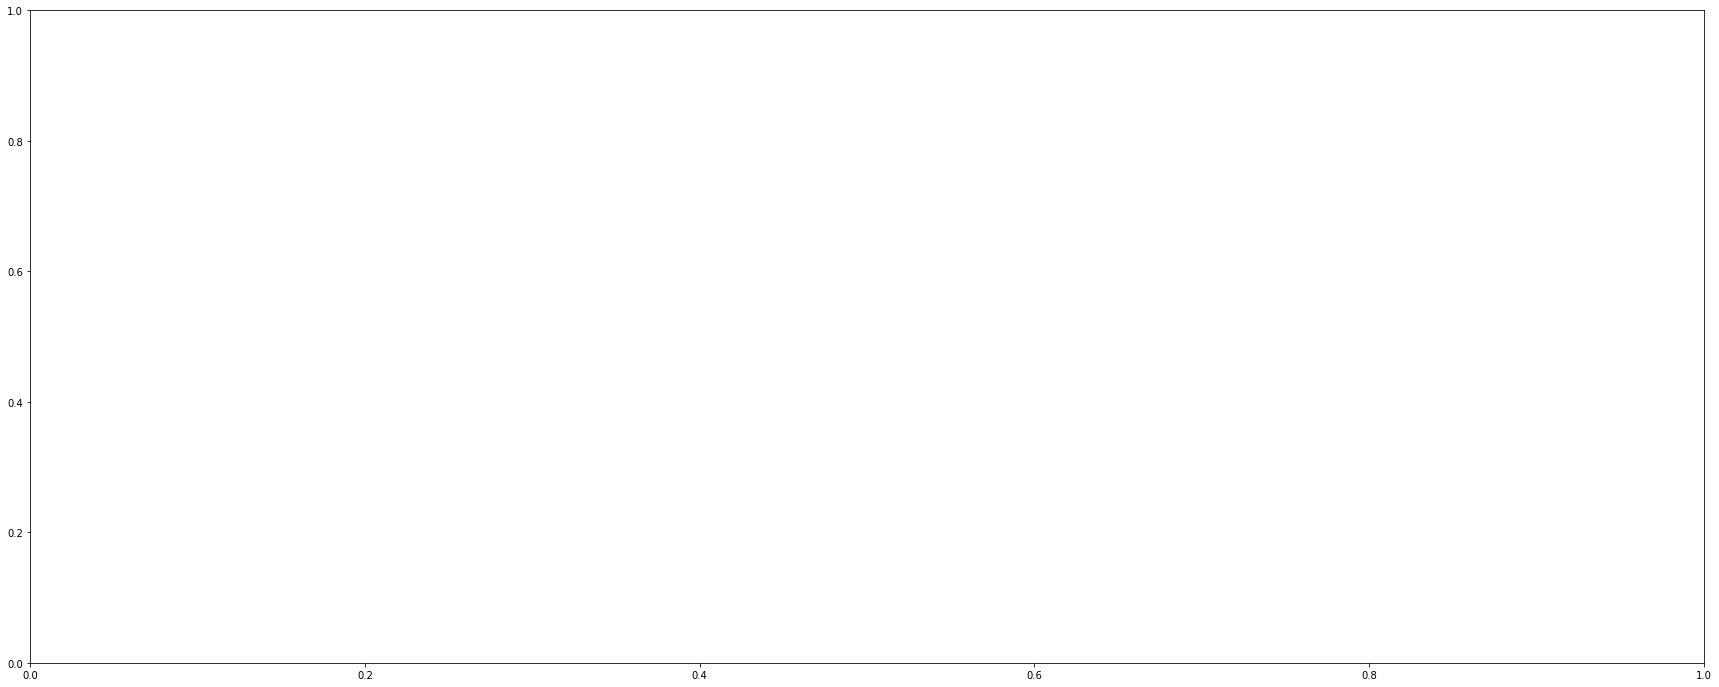

In [87]:
#Plotting The Top 10 Most Positive Residuals From The Logisitic Regression Model

fig, ax = plt.subplots(figsize=(30,12))
x_values =  coefficients_matrix.sort_values(by=0, ascending=False).head(10).index
sns.barplot(x=x_values, y='Logistic Regression Coefficients', data=coefficients_matrix.sort_values(by='0', ascending=False).head(10))
plt.title('The Top 10 Most Positive Coefficients From The Logisitic Regression Model', pad=30, fontsize='25')
plt.xlabel('Coefficients', fontsize='18', labelpad=30)
plt.ylabel('Counts', fontsize='18', labelpad=30)
plt.show()

In [ ]:
#Plotting The Top 10 Most Negative Residuals From The Logisitic Regression Model

fig, ax = plt.subplots(figsize=(30,12))
x_values =  coefficients_matrix.sort_values(by=0, ascending=True).head(10).index
sns.barplot(x=x_values, y='Logistic Regression Coefficients', data=coefficients_matrix.sort_values(by='0', ascending=True).head(10))
plt.title('The Top 10 Most Negative Coefficients From The Logisitic Regression Model', pad=30, fontsize='25')
plt.xlabel('Coefficients', fontsize='18', labelpad=30)
plt.ylabel('Counts', fontsize='18', labelpad=30)
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------

In [91]:
#Additional Feature Engineering - NLP Text Data

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X = cleaned_df.copy()
X = X.dropna(how='any')
X.drop(columns=['Companies', 'Salaries($)'], inplace=True)
X = pd.get_dummies(data=X, drop_first=True, columns=['State', 'Locations'])
y = X.pop('Salary_Class')

In [92]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)

X2_train_titles = vectorizer.fit_transform(X2_train['Titles'])
X2_test_titles = vectorizer.transform(X2_test['Titles'])

X2_train.drop(columns=['Titles'], inplace=True)
X2_test.drop(columns=['Titles'], inplace=True)

X_Train_Sparse = sparse.csr_matrix(X2_train.values)
X_Test_Sparse = sparse.csr_matrix(X2_test.values)

y2_train.reset_index(drop=True)
y2_test.reset_index(drop=True)

X2_train = sparse.hstack((X2_train_titles, X_Train_Sparse))
X2_test = sparse.hstack((X2_test_titles, X_Test_Sparse))

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [93]:
models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='auto'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

for model in models:
    print(model)
    model.fit(X2_train, y2_train)
    print(model.score(X2_train, y2_train))
    print(model.score(X2_test, y2_test))
    print(np.mean(cross_val_score(model, X2_test, y2_test, cv=5)))
    print('---------')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
0.7913043478260869
0.7068965517241379
0.6909090909090909
---------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
0.9347826086956522
0.7241379310344828


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.756060606060606
---------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
1.0
0.7241379310344828
0.6212121212121212
---------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.5304347826086957
0.5172413793103449
0.5363636363636364
---------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            mi

In [102]:
# Confusion Matrix +  Plot A ROC Curve + Precision Recall Curve Here.

In [103]:
log_reg_model = LogisticRegression(solver='lbfgs', multi_class='auto')
log_reg_model.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
predictions = log_reg_model.predict(X_test)

In [153]:
predictions

array(['HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'LOW SALARY', 'HIGH SALARY',
       'LOW SALARY', 'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY'], dtype=object)

In [106]:
conmat = np.array(confusion_matrix(y_test, predictions, labels=['LOW SALARY', 'HIGH SALARY']))

confusion_matrix = pd.DataFrame(conmat, index=['True', 'False'],
                         columns=['Predicted LOW Salary', 'Predicted High Salary'])
confusion_matrix

TypeError: 'DataFrame' object is not callable

In [108]:
def binarizer(item):
    if item == 'HIGH SALARY':
        return 1
    else:
        return 0

y_test = y_test.apply(binarizer)

In [130]:
log_reg_model.predict_proba(X_test)[:,1]

array([0.29736024, 0.27623521, 0.41907817, 0.72451942, 0.27733178,
       0.75907161, 0.4222254 , 0.74953496, 0.5826469 , 0.2455876 ,
       0.22482296, 0.86846068, 0.41907817, 0.26648803, 0.2440547 ,
       0.64737669, 0.75907161, 0.3134265 , 0.27114571, 0.58495833,
       0.49146988, 0.50889092, 0.43338843, 0.80767494, 0.5605142 ,
       0.63383467, 0.31541092, 0.26397128, 0.26730546, 0.86623193,
       0.6171987 , 0.25040433, 0.53145016, 0.176469  , 0.62526461,
       0.4589114 , 0.41907817, 0.42705716, 0.81003719, 0.46372521,
       0.43021994, 0.51225969, 0.26934441, 0.6171987 , 0.51050459,
       0.50727706, 0.42921288, 0.79782676, 0.35079258, 0.26478378,
       0.42806908, 0.38195617, 0.38104607, 0.51050459, 0.41907817,
       0.52984195, 0.26604271, 0.75326279])

In [159]:
new_array = []

for item in predictions:
    if item == 'HIGH SALARY':
        new_array.append(1)
    else:
        new_array.append(0)

In [160]:
predictions

array(['HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'LOW SALARY', 'HIGH SALARY',
       'LOW SALARY', 'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY'], dtype=object)

In [163]:
new_array = np.array(new_array)

In [140]:
probabilities = log_reg_model.predict_proba(X_test)

In [152]:
log_reg_model.predict(X_test)

array(['HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'LOW SALARY', 'HIGH SALARY',
       'LOW SALARY', 'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'LOW SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY', 'HIGH SALARY',
       'HIGH SALARY', 'LOW SALARY', 'HIGH SALARY', 'LOW SALARY',
       'HIGH SALARY', 'LOW SALARY'], dtype=object)

In [168]:
log_reg_model.score(X_test, y_test)

TypeError: '<' not supported between instances of 'str' and 'int'

In [135]:
y_test = y_test.reset_index(drop=True)

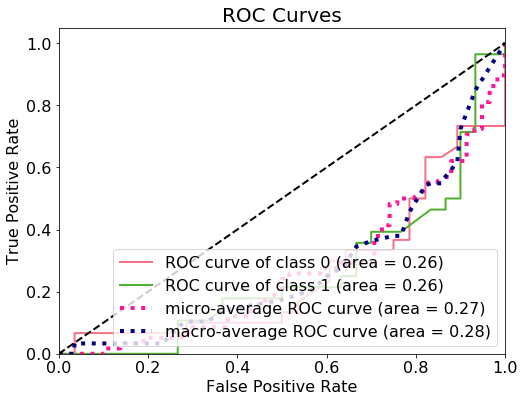

In [148]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report
cmap = ListedColormap(sns.color_palette("husl",3))

skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.show()

In [166]:
print(classification_report(y_test, new_array))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69        30
           1       0.67      0.79      0.72        28

   micro avg       0.71      0.71      0.71        58
   macro avg       0.71      0.71      0.71        58
weighted avg       0.71      0.71      0.71        58



In [101]:
# For class 1, find the area under the curve
precision, recall, threshold = precision_recall_curve(y_test, class_1_prob)

# Plot of a precision-recall curve for class 1 (benign)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

NameError: name 'class_1_prob' is not defined

In [89]:
# Performing A GridSearch On A Single Logistic Regression Model

In [90]:
#Logistic Regression..... Grid Search...

In [ ]:
params = {
    
}

In [ ]:
grid_search_model = GridSearchCV()

In [190]:
from sklearn.pipeline import Pipeline

# 😂😂😂 Creating And Learning Pipelines 😂😂😂
#7. TFID vectorizing - To Do
#8. Merging my TFID sparse matrix with my origin dataframe (train + test split objects.) - To Do

In [179]:
from sklearn.base import BaseEstimator, TransformerMixin

class Cleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self, X, salary_column= None, cols_to_drop = None, columns_to_dummify= None):
        self.salary_column = salary_column
        self.salary_median = X[self.salary_column].median()
        self.cols_to_drop = cols_to_drop
        self.columns_to_dummify= columns_to_dummify
        self.X = X
    
    #Creating The Salary Class 
    def salary_class(self):
        data = ['HIGH SALARY' if item > self.salary_median else 'LOW SALARY' for item in self.X['Salaries($)']]
        return data
    
    
    #Creating The States + Locations Features
    def state_and_locations(self):
        states = [str(item).split()[-1] for item in self.X['Locations']]
        locations = [(" ".join(str(item).split()[:-1])).replace(',','') for item in cleaned_df['Locations']]   
        return states, locations
    
    
    def dropping_cols(self):
        return self.X.drop(columns= self.cols_to_drop, inplace=True)
    
    
    def make_dummy_cols(self):
        for column in self.columns_to_dummify:
            try:
                categories = np.sort(self.X[column].unique())
                for category in categories[1:]:
                    self.X[column+'_'+str(category)] = self.X[column].map(
                        lambda x: 1 if x == category else 0)
                self.X = self.X.drop(column, axis=1)
            except:
                pass
        return self.X
    
    
    def transform(self, *args):
        #Cleaning & Adding Features.
        self.X['Salary_Class'] = self.salary_class()
        self.X['State'] = self.state_and_locations()[0]
        self.X['Locations'] = self.state_and_locations()[1]
        
        #Dropping Columns.
        self.dropping_cols()
        
        #Dropping NA Values.
        self.X.dropna(how='any', inplace=True)
        
        #Dummfying The Data
        self.make_dummy_cols()
        return self.X
        
    def fit(self, *args):
        pass

In [180]:
cleaned_df = pd.read_csv("exported_dataframe.csv")
Clean_mod = Cleaner(salary_column='Salaries($)', X = cleaned_df, cols_to_drop=['Companies', 'Salaries($)']
                   , columns_to_dummify = ['State', 'Locations'] )
X = Clean_mod.transform()
y = X.pop('Salary_Class')

In [181]:
X

,Titles,Ratings,State_CA,State_CO,State_DE,State_FL,State_GA,State_IL,State_NJ,State_NY,...,Locations_South San Francisco,Locations_Tacoma,Locations_Tempe,Locations_Torrance,Locations_Vancouver,Locations_Voorhees,Locations_Webster,Locations_West Point,Locations_Willow Grove,Locations_Wilmington
152,MTC Technical Architect-Data & AI,87.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
153,Management Operations Analyst II,73.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
154,Data Scientist,65.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
155,Research Analyst - Oakton Community College,89.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
156,Data Science Educator,73.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157,"Computer Scientist, ZP-1550-II (GS-7/10 equiva...",87.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158,Data Scientist - Bioinformatics,71.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
160,Data Scientist,73.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161,Chemistry Program Manager - 2040,70.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162,UX Copywriter / Content Strategist,72.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
#Performing A Train Test Split.

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=1, stratify=y)

In [192]:
# Create a TFID_Vectorizer Helper Class For The Pipeline!

from sklearn.feature_extraction.text import TfidfVectorizer

class TFID_Vectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, X, cols_to_vectorize = None):
        self.cols_to_vectorize = cols_to_vectorize   
        self.fitted_results = None
        self.tvec = TfidfVectorizer(stop_words='english')
        
    def fit(self, X, y=None, *args):
        self.tvec.fit(X[self.cols_to_vectorize])
        return self.tvec
    
    def transform(self, X, y=None, *args):
        if isinstance(X, pd.DataFrame):
            X = self.tvec.transform(X[self.cols_to_vectorize])
            return X
        else:
            return X

In [193]:
testing = TFID_Vectorizer(X, cols_to_vectorize='Titles')

In [187]:
testing.fitted_results

In [186]:
process_text(rt['quote'][:2], pos=pos)

NotFittedError: TfidfVectorizer - Vocabulary wasn't fitted.

In [70]:
testing.tvec

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [71]:
testing.transform(X_test)

<58x304 sparse matrix of type '<class 'numpy.float64'>'
	with 175 stored elements in Compressed Sparse Row format>

In [23]:
X_test

,Titles,Ratings,State_CA,State_CO,State_DE,State_FL,State_GA,State_IL,State_NJ,State_NY,...,Locations_South San Francisco,Locations_Tacoma,Locations_Tempe,Locations_Torrance,Locations_Vancouver,Locations_Voorhees,Locations_Webster,Locations_West Point,Locations_Willow Grove,Locations_Wilmington
381,Senior Software Engineer- Machine Learning,67.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
506,"Manager, Software Development (Woot LLC, Seatt...",51.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,Research Programmer II,87.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
347,Data Scientist - Fraud,67.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
373,"Senior Software Engineer, Machine Learning",74.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176,OPERATIONS RESEARCH,88.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,REALTY SPECIALIST,89.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
439,Research General Engineer/Research Physical Sc...,87.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
445,Post Doctoral Fellow,88.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
524,"Data Scientist - Principal - San Francisco, CA",70.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Stemming
#Changing the paramatetrs min - max features
#N-grams

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [ ]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 